In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import requests
import os
import matplotlib.pyplot as plt

In [2]:
from dotenv import load_dotenv
import os
load_dotenv()  # reads the .env file automatically

True

## Load energy consumption data for the state of California

In [3]:
import os, requests, pandas as pd

API_KEY = os.getenv("EIA_KEY")  # set first: export EIA_KEY="your_key"
BASE = "https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/"

COMMON = {
    "frequency": "daily",
    "data[0]": "value",
    "facets[respondent][]": "CAL",
    "facets[timezone][]": "Pacific",      # << your addition
    "start": "2019-01-01",
    "end":   "2025-12-10",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",         # keep your sort direction
    "length": 5000,
}

def fetch_all_daily():
    rows, offset, total = [], 0, None
    while True:
        params = COMMON.copy()
        params["api_key"] = API_KEY
        params["offset"]  = offset

        r = requests.get(BASE, params=params, timeout=60)
        r.raise_for_status()
        resp = r.json()["response"]

        if total is None:
            total = int(resp.get("total", 0))

        chunk = resp.get("data", [])
        rows.extend(chunk)
        print(f"Fetched {len(chunk):4d} rows @ offset {offset:,} "
              f"({len(rows):,}/{total:,})")

        if len(chunk) < params["length"] or offset + params["length"] >= total:
            break
        offset += params["length"]

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    # Parse / clean
    # 'period' is daily like 'YYYY-MM-DD' (Pacific-local calendar day)
    df["period"] = pd.to_datetime(df["period"], format="%Y-%m-%d", errors="coerce")
    df["value"]  = pd.to_numeric(df["value"], errors="coerce")

    # Keep useful columns if present
    keep = ["period","respondent","respondent-name","fueltype","type-name",
            "timezone","value","value-units"]
    df = df[[c for c in keep if c in df.columns]].sort_values(["period","fueltype"])

    return df

if __name__ == "__main__":
    df_daily = fetch_all_daily()
    print("Daily shape:", df_daily.shape)
    if not df_daily.empty:
        df_daily.to_csv("eia_CAL_fueltype_daily_Pacific_2019_2025-09-27.csv", index=False)
        print(df_daily.head(10))

Fetched 5000 rows @ offset 0 (5,000/21,634)
Fetched 5000 rows @ offset 5,000 (10,000/21,634)
Fetched 5000 rows @ offset 10,000 (15,000/21,634)
Fetched 5000 rows @ offset 15,000 (20,000/21,634)
Fetched 1634 rows @ offset 20,000 (21,634/21,634)
Daily shape: (21634, 8)
          period respondent respondent-name fueltype    type-name timezone  \
21626 2019-01-01        CAL      California      COL         Coal  Pacific   
21627 2019-01-01        CAL      California       NG  Natural Gas  Pacific   
21628 2019-01-01        CAL      California      NUC      Nuclear  Pacific   
21629 2019-01-01        CAL      California      OIL    Petroleum  Pacific   
21630 2019-01-01        CAL      California      OTH        Other  Pacific   
21631 2019-01-01        CAL      California      SUN        Solar  Pacific   
21632 2019-01-01        CAL      California      WAT        Hydro  Pacific   
21633 2019-01-01        CAL      California      WND         Wind  Pacific   
21618 2019-01-02        CAL    

In [5]:
df_daily.head()

,period,respondent,respondent-name,fueltype,type-name,timezone,value,value-units
21626,2019-01-01,CAL,California,COL,Coal,Pacific,36021,megawatthours
21627,2019-01-01,CAL,California,NG,Natural Gas,Pacific,199638,megawatthours
21628,2019-01-01,CAL,California,NUC,Nuclear,Pacific,54565,megawatthours
21629,2019-01-01,CAL,California,OIL,Petroleum,Pacific,2150,megawatthours
21630,2019-01-01,CAL,California,OTH,Other,Pacific,17823,megawatthours


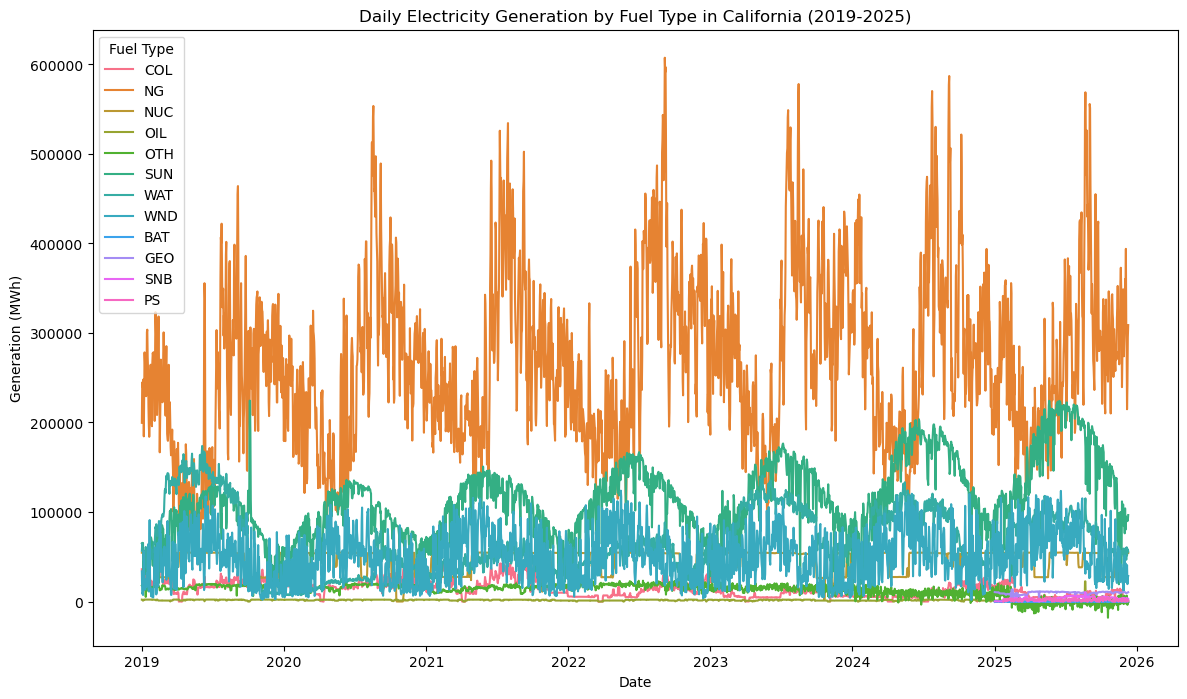

In [6]:
# Plotting total daily generation by fuel type
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_daily, x='period', y='value', hue='fueltype')
plt.title('Daily Electricity Generation by Fuel Type in California (2019-2025)')
plt.xlabel('Date')
plt.ylabel('Generation (MWh)')
plt.legend(title='Fuel Type')
plt.show()

In [8]:
# Types of fuel used
fuel_types = df_daily['type-name'].unique()
print("Fuel types used in California:", fuel_types)

Fuel types used in California: ['Coal' 'Natural Gas' 'Nuclear' 'Petroleum' 'Other' 'Solar' 'Hydro' 'Wind'
 'Battery storage' 'Geothermal' 'Solar with integrated battery storage'
 'Pumped storage']


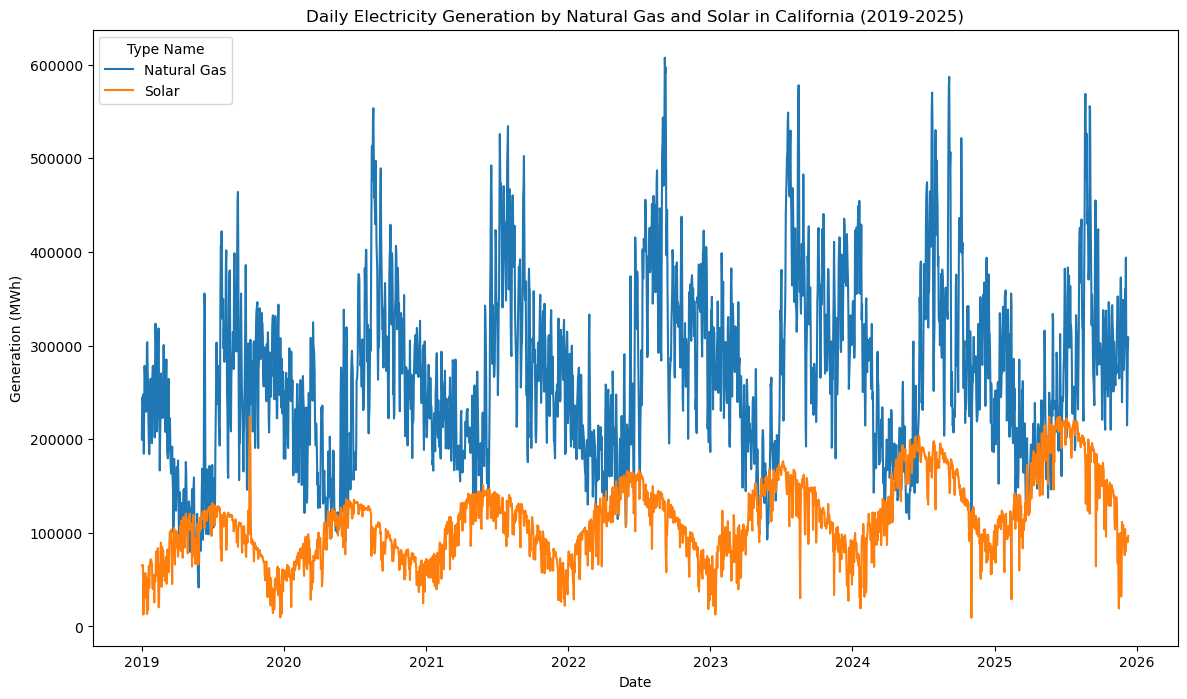

In [14]:
# Plotting total daily generation by type name Natural gas and Petroleum
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_daily[df_daily['type-name'].isin(['Natural Gas', 'Solar'])], 
             x='period', y='value', hue='type-name')
plt.title('Daily Electricity Generation by Natural Gas and Solar in California (2019-2025)')
plt.xlabel('Date')
plt.ylabel('Generation (MWh)')
plt.legend(title='Type Name')
plt.show()

Natural gas is the largest overall contributor to electricity generation, but its output fluctuates throughout the year. During the summer months, increased contributions from renewable sources—particularly solar energy—coincide with a decline in natural gas generation, indicating a seasonal substitution effect between these energy sources.

<Axes: title={'center': 'Total Electricity Generation by Fuel Type in California (2019-2025)'}, ylabel='value'>

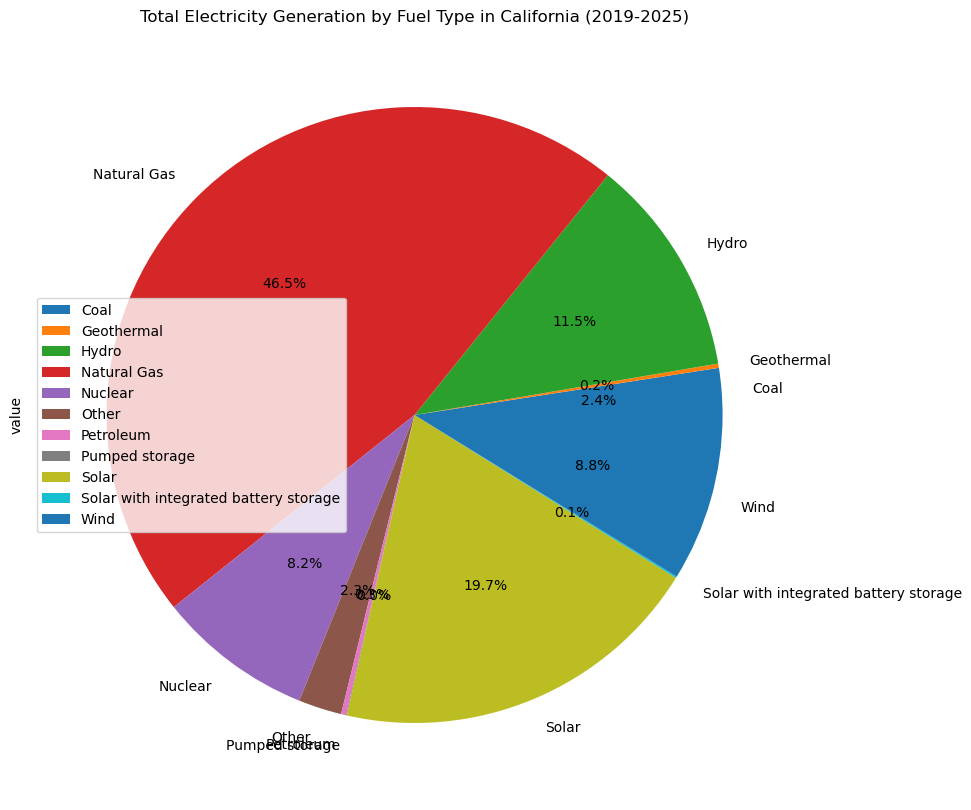

In [21]:
# Aggregate total generation by fuel type in a pie chart
total_generation = df_daily.groupby('type-name')['value'].sum().reset_index()
total_generation = total_generation[total_generation['value'] > 0]  # Filter out zero values
total_generation.plot.pie(y='value', labels=total_generation['type-name'], autopct='%1.1f%%', figsize=(10, 10), title='Total Electricity Generation by Fuel Type in California (2019-2025)')

In [22]:
# Sum values across all fuel types per day
daily_total = (
    df_daily.groupby("period", as_index=False)["value"]
            .sum()
            .rename(columns={"value": "total_value"})
)

# Now daily_total has only 'period' and 'total_value' columns
print(daily_total.head())


      period  total_value
0 2019-01-01       465701
1 2019-01-02       488901
2 2019-01-03       484062
3 2019-01-04       477305
4 2019-01-05       451001


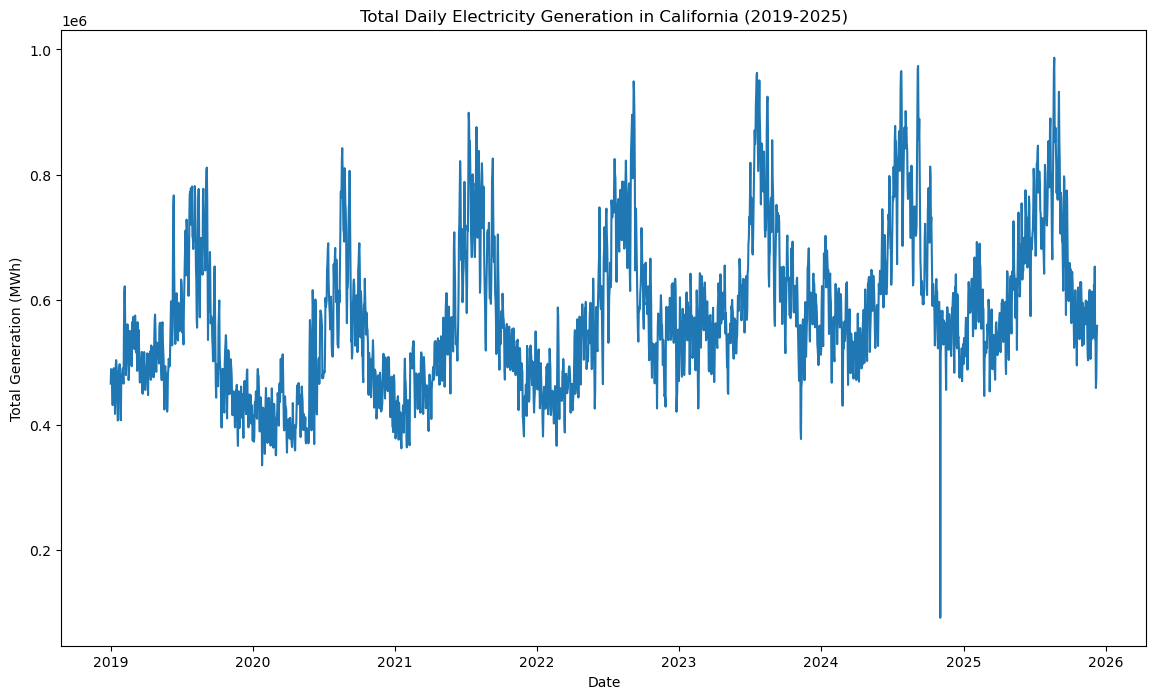

In [23]:
# plot the daily total generation
plt.figure(figsize=(14, 8))
sns.lineplot(data=daily_total, x='period', y='total_value')
plt.title('Total Daily Electricity Generation in California (2019-2025)')
plt.xlabel('Date')
plt.ylabel('Total Generation (MWh)')
plt.show()


We can clearly see a pattern of yearly seasonality. However lets dive in to see any traces of weekly seasonality

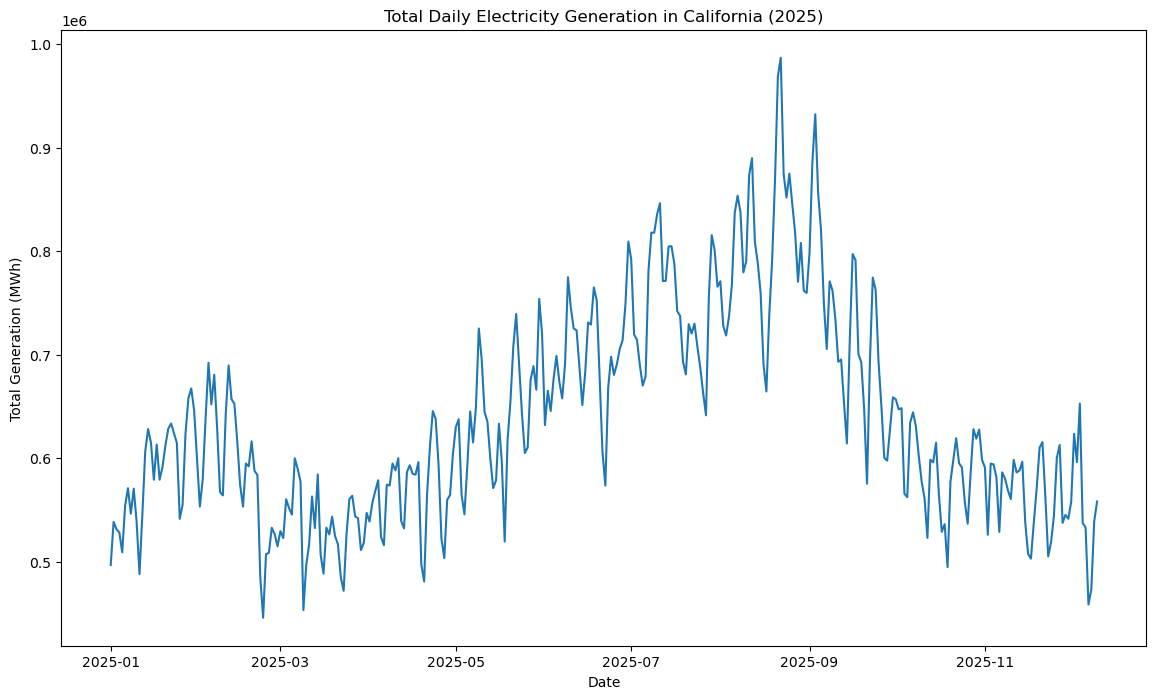

In [24]:
# Plot the daily total generation for the year 2025
plt.figure(figsize=(14, 8))
sns.lineplot(data=daily_total[daily_total['period'].dt.year == 2025], x='period', y='total_value')
plt.title('Total Daily Electricity Generation in California (2025)')
plt.xlabel('Date')
plt.ylabel('Total Generation (MWh)')
plt.show()

Peaks and valleys are visible throughout the year following the seasonal oscillation line indicating weekly seasonality as well

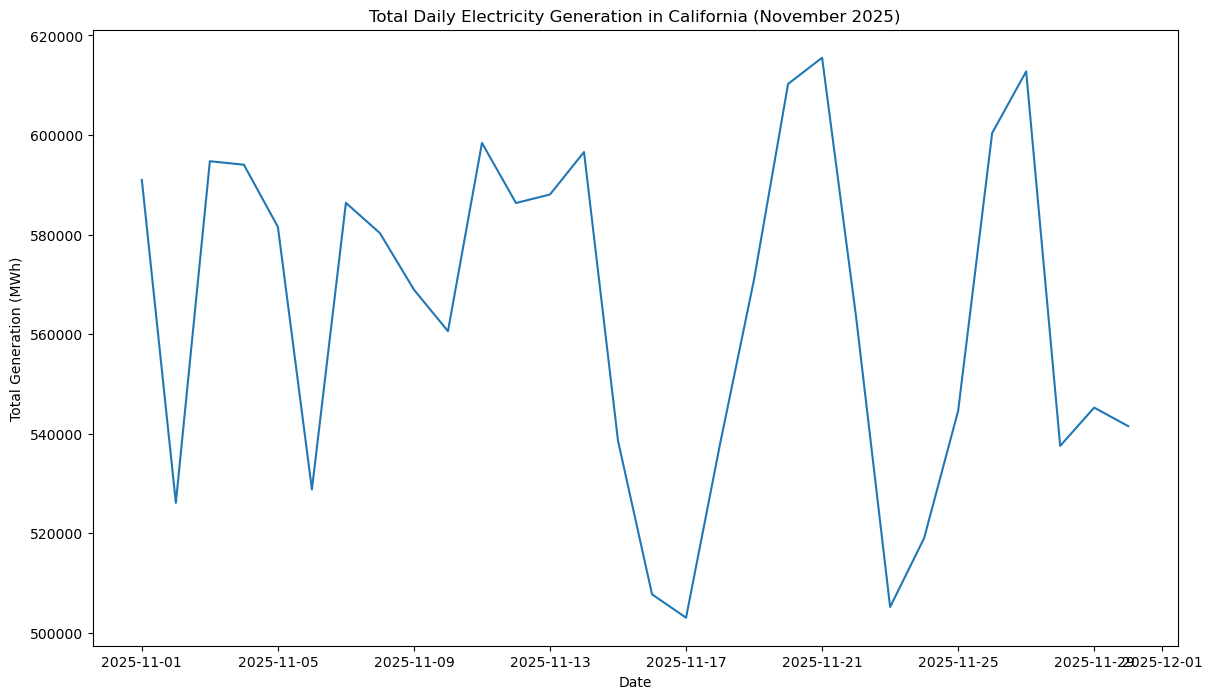

In [25]:
# Plot the daily total generation for the month of november 2025
plt.figure(figsize=(14, 8))
sns.lineplot(data=daily_total[(daily_total['period'].dt.year == 2025) & (daily_total['period'].dt.month == 11)], x='period', y='total_value')
plt.title('Total Daily Electricity Generation in California (November 2025)')
plt.xlabel('Date')
plt.ylabel('Total Generation (MWh)')
plt.show()

We see peaks occur during weekends followed by valleys occuring during the start of weekdays

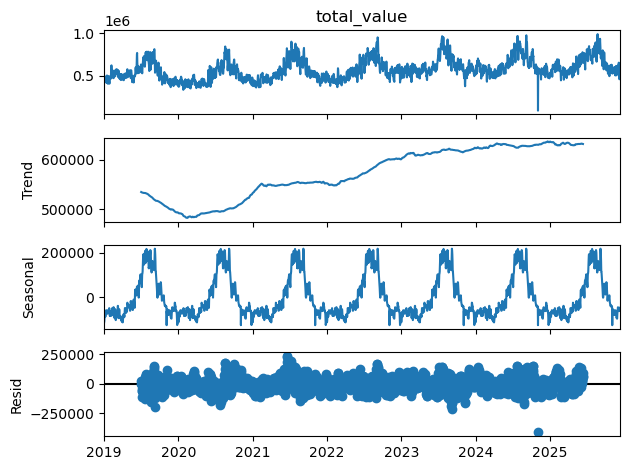

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose the time series to observe trend and seasonality
daily_total.set_index('period', inplace=True)
decomposition = seasonal_decompose(daily_total['total_value'], model='additive', period=365)
decomposition.plot()
plt.show()

The upward trend is visible after the year 2020( covid ) and the sasonal pattern is observed in the decomposition. Lets see if a first order differenced series fixes the trend

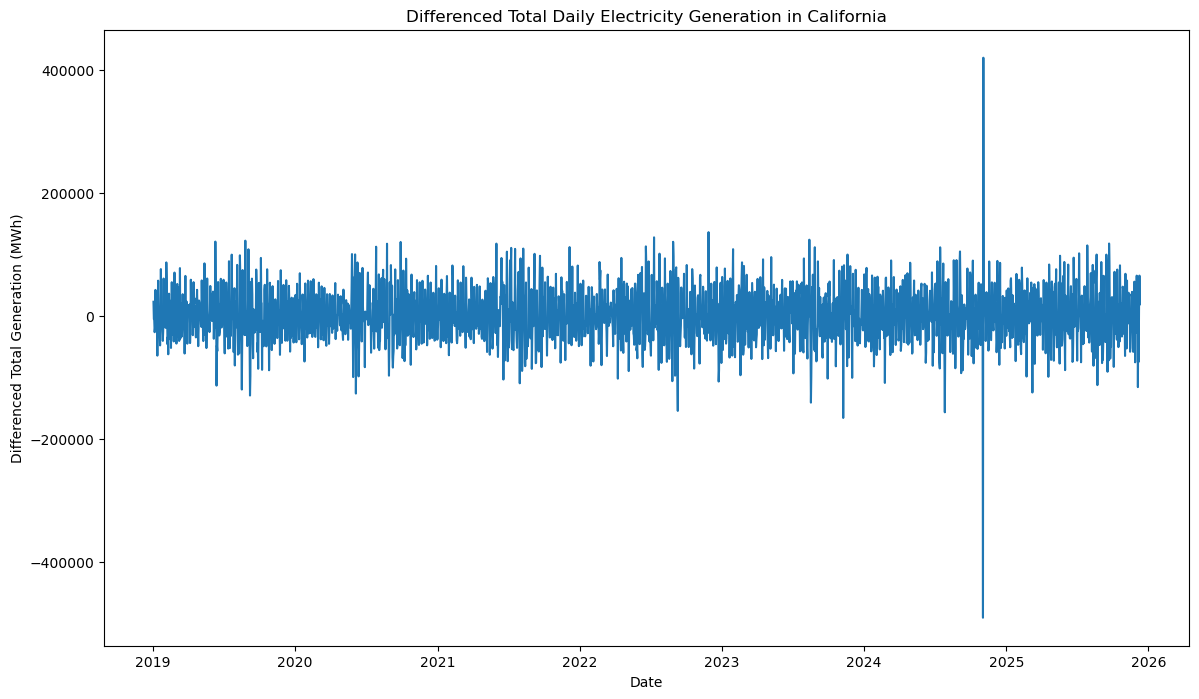

In [29]:
# Set period as index
daily_total.reset_index(inplace=True)
daily_total.set_index('period', inplace=True)
daily_total['differenced'] = daily_total['total_value'].diff()
plt.figure(figsize=(14, 8))
sns.lineplot(data=daily_total, x=daily_total.index, y='differenced')
plt.title('Differenced Total Daily Electricity Generation in California')
plt.xlabel('Date')
plt.ylabel('Differenced Total Generation (MWh)')
plt.show()


A first order differencing removes the linear trend, this will be useful later when we try to forecast. Now lets look at the ACF and PACF plots

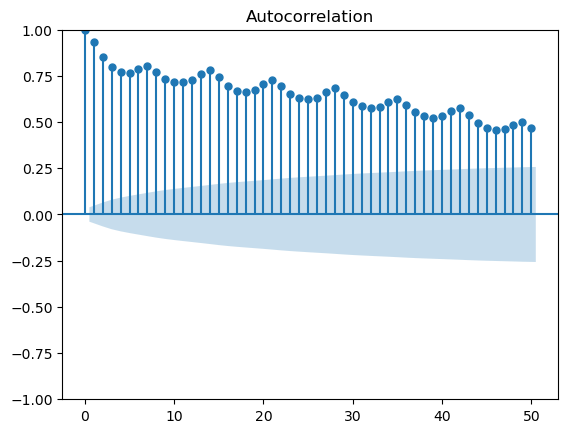

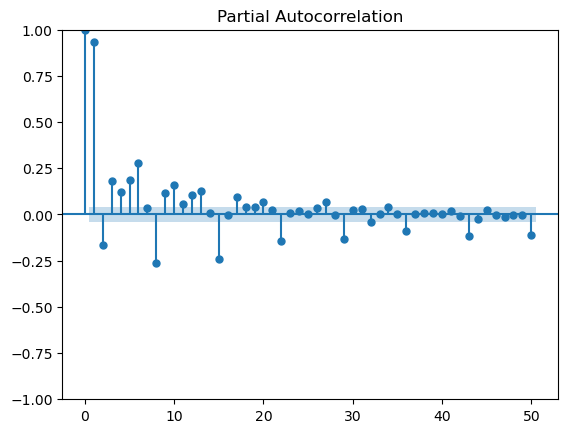

In [32]:
# Plot the ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(daily_total["total_value"], lags=50)
plt.show()
plot_pacf(daily_total["total_value"], lags=50)
plt.show()

For the ACF we see a decay with no cutoff indicating it is not a MA(q) process (q=0). For the PACF we see a sharp spike a lag 1 (AR(1) process) and then a sharp decline. We also see a slightly significant spike at lag = 7 which might indicate a seasonal order of 7. 

In [34]:
daily_total.to_csv("total_data.csv", index=True)